# BIS Central Bank Policy Rate data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li></ul></li><li><span><a href="#Central-Bank-Policy-Data/Charts" data-toc-modified-id="Central-Bank-Policy-Data/Charts-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Central Bank Policy Data/Charts</a></span><ul class="toc-item"><li><span><a href="#Get-Bank-for-International-Settlements-(BIS)-Data" data-toc-modified-id="Get-Bank-for-International-Settlements-(BIS)-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get Bank for International Settlements (BIS) Data</a></span></li><li><span><a href="#Plot-individual-central-bank-policy-rates-over-the-recent-past" data-toc-modified-id="Plot-individual-central-bank-policy-rates-over-the-recent-past-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot individual central bank policy rates over the recent past</a></span></li><li><span><a href="#Look-at-tightening-cycles" data-toc-modified-id="Look-at-tightening-cycles-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Look at tightening cycles</a></span></li><li><span><a href="#Summary-charts---from-2021-Covid-until-now" data-toc-modified-id="Summary-charts---from-2021-Covid-until-now-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Summary charts - from 2021 Covid until now</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python setup

### Imports

In [1]:
# analytic imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe

# system imports
from pathlib import Path
from datetime import date

# local imports
from finalise_plot import finalise_plot
from rba_common import plot_series_highlighted
from common import get_bis_cbpr

In [2]:
# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use('fivethirtyeight')

# Where to put the charts
CHART_DIR = "./charts/OECD"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)

# Remove old charts
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()

## Central Bank Policy Data/Charts

### Get Bank for International Settlements (BIS) Data

In [3]:
bis_meta, bis_data = get_bis_cbpr()

### Plot individual central bank policy rates over the recent past

In [4]:
RECENT = pd.Period('2017-12-31')
data_r = bis_data[bis_data.index >= RECENT]
for nation in data_r.columns:
    ax = data_r[nation].plot(lw=2, drawstyle='steps-post',)
    title = f'Central Bank Policy Rate for {nation}'
    finalise_plot(
        ax, title, 
        'Per cent', 
        '', CHART_DIR,
        rfooter=f'Data source: BIS as at {bis_data.index[-1]}',
        #show=True,
    )

### Look at tightening cycles

In [5]:
# Central banks started adopted an inflation-targeting
# approaches in the late 1980s and early 1990s.
# This is usually marked by less frequent changes to the policy rate
# with thos changes being in the order of 0.1 of a percentage point or higher.

STANDARD_FROM = '1993-01-01' 
FROM_1999 = '1999-07-01'
FROM_1998 = '1998-07-01'

odd_start = {
    # late adoption of infrequent (ie. <= monthly) changes to rates
    # or for other reasosn we exclude earlier data 
    'Denmark': FROM_1998,
    'Hong Kong SAR': '1998-09-01', 
    
    'Chile': FROM_1999,
    'Czechia': FROM_1999,
    'New Zealand':  FROM_1999,
    'Israel': FROM_1999,
    'Malaysia': FROM_1999,
    'Poland': FROM_1999,
    'India': FROM_1999,
    
    'Canada': '1996-07-01',
    'Norway': '1995-01-01',
    'Sweden': '1994-01-01',
    'Brazil': '2000-01-01',
    'Switzerland': '1992-01-01',
    'Russia': '2002-01-01', 
}

ignore = {'Argentina', 'Croatia', 'North Macedonia',
          'Mexico', 'Serbia', 'Philippines', }

for nation in bis_data.columns:
    
    if nation in ignore:
        continue
    
    selected = bis_data[nation].dropna()
    from_ = STANDARD_FROM if nation not in odd_start.keys() else odd_start[nation]
    selected = selected[selected.index >= from_]

    # The Australian data has some odd rounding for some dates
    # roughly in the order of a few 1/1000 of a percent. 
    # Lets force all the data to be in whole basis points. 
    selected = (selected * 100).round(0) / 100

    ax = plot_series_highlighted(selected, threshhold=0.001)
    
    finalise_plot(
        ax, 
        f'Central Bank Policy Rate - {nation} - Tightening Cycles', 
        'Per cent', 
        '', CHART_DIR,
        rfooter=f'Data source: BIS as at {bis_data.index[-1]}',
        #show=True,
    )

### Summary charts - from 2021 Covid until now

In [6]:
# get central bank policy movement
KEY_DATE = '2021-01-01'
MID_COVID = pd.Period(KEY_DATE, freq='D')
PLUS_MINUS = 180 
minima = bis_data[
    (bis_data.index >=  MID_COVID - PLUS_MINUS)
    & (bis_data.index <=  MID_COVID + PLUS_MINUS)
].min()
current = bis_data.iloc[-1]
movement = current - minima

# dropping Argentina because the movement is so large.
movement = movement.drop('Argentina').sort_values()

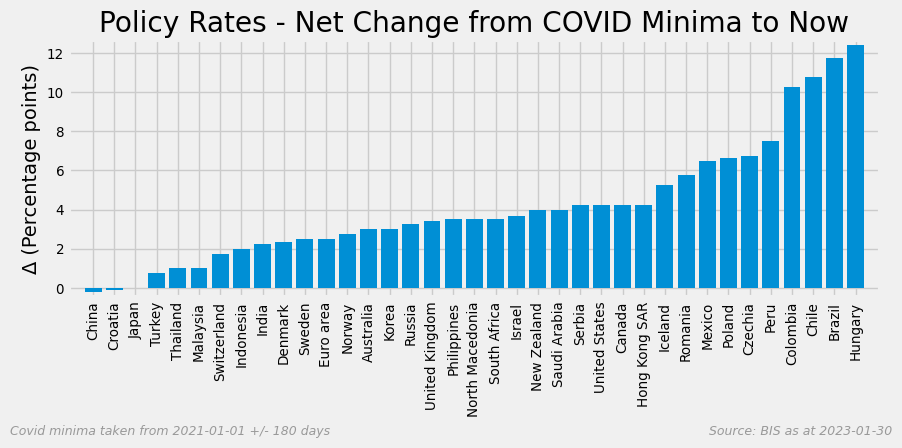

In [21]:
# plot
ax = movement.plot.bar(width=0.8)
ax.tick_params(axis='both', which='major', labelsize='x-small')
ax.set_ylabel('Δ (Percentage points)', fontsize='medium')
title = 'Policy Rates - Net Change from COVID Minima to Now'
finalise_plot(
        ax, title, 
        'Δ (Percentage points)', 
        '', CHART_DIR,
        rfooter=f'Source: BIS as at {bis_data.index[-1]}',
        lfooter=f'Covid minima taken from {KEY_DATE} +/- {PLUS_MINUS} days',
        show=True,
    )

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_63151/3712505933.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, rotation = 90)


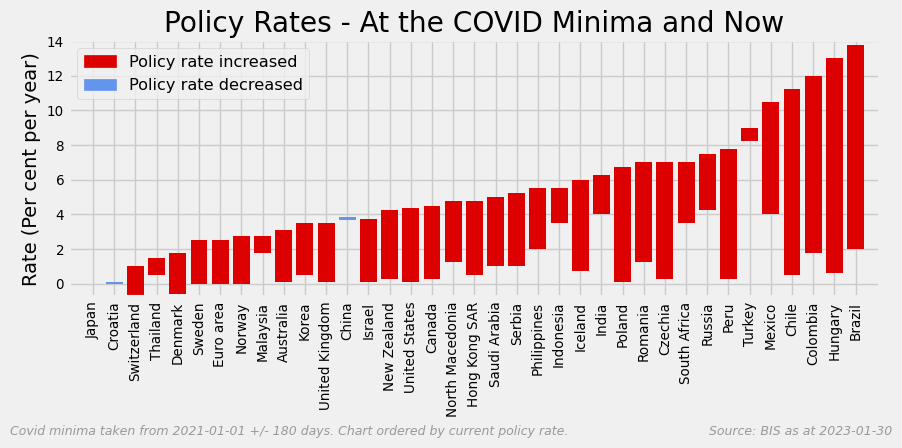

In [23]:
# plot in a candlestick style
curr = current.drop('Argentina').sort_values()
mini = minima[curr.index]
xticklabels = curr.index.to_list()

up, down = '#dd0000','cornflowerblue' 
colours = [up if c > m else down for c, m in zip(curr, mini)]
height = (mini - curr).abs()
bottom = pd.DataFrame([curr, mini]).min()

fig, ax = plt.subplots()
ax.bar(
    x=xticklabels,
    height=height,
    bottom=bottom,
    color=colours
)
ax.set_xticklabels(xticklabels, rotation = 90)
ax.tick_params(axis='both', which='major', labelsize='x-small')
ax.set_ylabel('Rate (Per cent per year)', fontsize='medium')

up_patch = mpatches.Patch(color=up, label='Policy rate increased')
down_patch = mpatches.Patch(color=down, label='Policy rate decreased')
ax.legend(handles=[up_patch, down_patch], loc='best', fontsize='small')

title = 'Policy Rates - At the COVID Minima and Now'
finalise_plot(
        ax, title, 
        'Rate (Per cent per year)', 
        '2', CHART_DIR,
        rfooter=f'Source: BIS as at {bis_data.index[-1]}',
        lfooter=f'Covid minima taken from {KEY_DATE} +/- {PLUS_MINUS} days. '
                'Chart ordered by current policy rate.',
        show=True,
    )

## Finished

In [9]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Feb 09 2023 11:43:47

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.7.0

matplotlib: 3.6.3
pandas    : 1.5.3

Watermark: 2.3.1



In [10]:
print('Done')

Done
